##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [21]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
importlib.reload(Dense)
importlib.reload(RSTF)

# %matplotlib notebook
%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from ipywidgets import FloatProgress
from IPython.display import display
import os

from keras.models import model_from_json
import ReadStandardTimeFill as RSTF
# pool.close()

In [22]:
def TTV_Split(iteration,Memory,X,y,params,X_fill):
    if params['Save']['Model']==True:
        params['Save']['Weights'] = True
    params['seed'] = int(iteration%params['splits_per_mod']/params['splits_per_mod']*100)
    params['iteration'] = int(iteration/params['splits_per_mod'])
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=params['seed'])
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=params['seed'])
    return(Dense.Train_Steps(params,X_train,X_test,X_val,y_train,y_test,
        y_val,X_fill = X_fill,Memory=Memory),
        y_val,params)

PPFD_Thresh=10
def RunReps(Model,params,Runs,ax,Exclusion=False):
    RST = RSTF.ReadStandardTimeFill(params['Dpath']+'ECData.csv',CombineKeys=['Combined',
                                  ['Shrub','Grass','Sparse','Water']])
    print(RST.Master[params['Y']].mean())
    plt.figure()
    plt.scatter(RST.Master[params['Y']],RST.Master['PPFD_Avg'])
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    RMSE = []
    RST.Scale(params['Y'],Model)
    y = RST.y*1.0
    X = RST.X*1.0
    ## Exclusion Rule
    NSamp = int(RST.y.shape[0]*.1)
    if Exclusion == True:
        X = RST.XScaled.transform(RST.Data.loc[RST.Data['PPFD_Avg']>=PPFD_Thresh,Vars])
        y = RST.YScaled.transform(RST.Data.loc[RST.Data['PPFD_Avg']>=PPFD_Thresh,params['Y']].values.reshape(-1, 1))
        NSamp = int(RST.y.shape[0]*.1)
    
    X_fill = RST.X_fill*1.0
    Yval = []
    y_val= []
    for i in range(params['K']):
        results = TTV_Split(i,Memory,X,y,params,X_fill)
        Yfill = RST.YScaled.inverse_transform(results[0][0].reshape(-1,1))
        Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
        y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
        Runs['RMSE'].iloc[i] = metrics.mean_squared_error(y_val,Yval)
        Runs['R2'].iloc[i] = metrics.r2_score(y_val,Yval)
        params=results[2]
        Runs['iteration'].iloc[i] = params['iteration']
        Runs['seed'].iloc[i] = params['seed']
        
#         ax.scatter(RST.Master['wind_speed'],RST.Master['fco2']*1e-6 * 44.0095 *3600)
        ax.scatter(y_val,Yval)
        ax.set_ylabel('Fill')
#         plt.colorbar(cb)
    return(Runs,NSamp)

{'proc': 1, 'K': 4, 'epochs': 200, 'Y': 'fco2', 'splits_per_mod': 2, 'Save': {'Weights': False, 'Model': True}, 'Dpath': 'C:\\Users\\wesle\\NetworkAnalysis/Illisarvik/', 'N': 34, 'Model': 'PPFD_Avg+wind_speed+Temp+VWC+Out_of_Basin'}
-0.28395052688269223
Saved model to disk


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


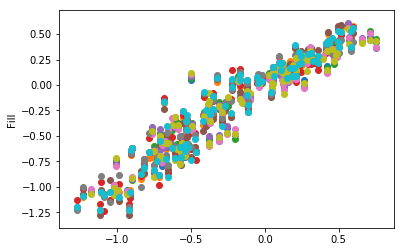

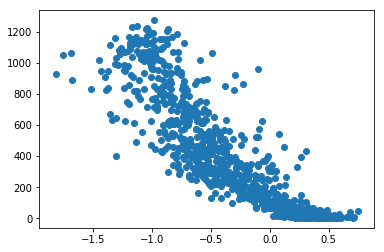

In [28]:
FillVar = 'fco2'
Site = 'Illisarvik'
Vars = ['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VPD', 'VWC', 'Sedge']#
Vars = ['wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VPD','VWC','Sedge']#
# Vars = ['wind_speed', 'PPFD_Avg']
Vars = ['PPFD_Avg','wind_speed','Temp','VWC','Out_of_Basin']
# Vars = ['wind_speed', 'H', 'VPD', 'Temp', 'VWC', 'Sedge','Combined',
#         'Out_of_Basin','air_pressure']


N = 34

# Path = 
fig,ax = plt.subplots()
Runs,params = Dense.Params('Test',FillVar,MP=False)
cwd = os.getcwd()
params['Dpath'] = cwd+'/'+Site+'/'
Runs['iteration'] = 0
Runs['seed'] = 0
params['Dpath']=os.getcwd()+'/'+Site+'/'

params['N'] = N
params['Save']['Model'] = True
params['Model'] = '+'.join(Vars)
params['epochs']=200
print(params)
params['K']=10

Runs = Runs.iloc[0:params['K']].drop('Model',axis=1)
Runs['N'] = params['N']
Runs,NSamp = RunReps(Vars,params,Runs,ax,Exclusion=False)


In [29]:
print(Runs.mean()['RMSE']**.5)

print(Runs)

0.14986655055054268
    N      RMSE        R2  iteration  seed
0  34  0.019611  0.911861          0     0
1  34  0.018826  0.923251          0    50
2  34  0.021762  0.902193          1     0
3  34  0.026705  0.891134          1    50
4  34  0.022320  0.899685          2     0
5  34  0.019321  0.921233          2    50
6  34  0.022638  0.898253          3     0
7  34  0.025732  0.895098          3    50
8  34  0.024713  0.888931          4     0
9  34  0.022972  0.906351          4    50


In [30]:
def Load_Model(params):
    json_file = open(params['Dpath']+'/'+params['Y']+'/Weights/'+params['Model']+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return(loaded_model)
def Load_Weights(loaded_model,i,s):
    loaded_model.load_weights(params['Dpath']+'/'+params['Y']+'/Weights/'+params['Model']+'_'+str(i)+'_'+str(s)+'.h5')
    loaded_model.compile(loss='mean_squared_error', optimizer='adam')
#     print("Loaded model from disk")
    return(loaded_model)
# print(Model)## Allows for calculation of partial derivatives & Mapping a over one dimension by fixing all other dimensions
def Fix(RST,Model,params,Vars,d,Fixed_Vals):
    di = [i for i,x in enumerate(Vars) if x == d]
    RST.Scale(params['Y'],Vars)
    y = RST.y*1.0
    X = RST.X*1.0
    Fixers = RST.XScaled.transform([Fixed_Vals])
    Xnu = RST.X_fill*1.0
    Xnu[:,di]=Fixers[:,di]
    return(Xnu,RST,Fixers[:,di])


PPFD_Avg        1.757000
wind_speed      3.867765
Temp            7.221985
VWC             0.548899
Out_of_Basin    0.124064
dtype: float64
CI:  0.10559587733161022
0.31661462783813477


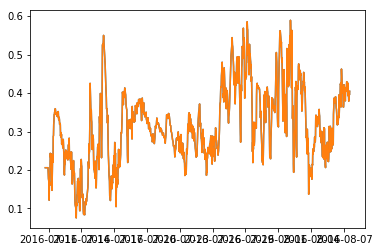

In [31]:
Model = Load_Model(params)
RST = RSTF.ReadStandardTimeFill(params['Dpath']+'ECData.csv',CombineKeys=['Combined',
                                      ['Shrub','Grass','Sparse','Water']])

dx = 'PPFD_Avg'
Var = 'PPFD_Avg'
Fixed_Vals = RST.Master[Vars].mean()
Fixed_Vals[Var]=RST.Master[Var].min()
print(Fixed_Vals)
X,RST,di=Fix(RST,Model,params,Vars,dx,Fixed_Vals.values)
EmptyModel = Load_Model(params)
results = []
for i,s in zip(Runs['iteration'],Runs['seed']):
    Model = Load_Weights(EmptyModel,i,s) 
#     Yfill=RST.YScaled.inverse_transform(Model.predict(RST.X_fill).reshape(-1,1))
    Yfill=Model.predict(X)
    results.append(Yfill)
Yfill = np.asanyarray(results).mean(axis=0)

RST.Fill(Yfill,'fco2')
RST.Master['Fill']=RST.YScaled.inverse_transform(Yfill)
Yfill = RST.YScaled.inverse_transform(Yfill.reshape(-1,1))#*1e-6 * 44.0095 *3600
RST.Master.loc[RST.Master['TempFill']<0,'TempFill']=np.nan
RST.Master['TempFill'].bfill()
RST.Master['TempFill'].ffill()
plt.plot(RST.Master['TempFill'])
plt.plot(RST.Master['Fill'])
# RST.Master['TempFill']*=1e-6 * 44.0095 *3600
Hourly = RST.Master.loc[(RST.Master['PPFD_Avg']<PPFD_Thresh)&(RST.Master['fco2']>0)]
# Hourly['Diff'] = Hourly['fco2']-Hourly['TempFill']
# print(Hourly[['TempFill','fco2']].mean())
print('CI: ',Runs['RMSE'].mean()**.5/(params['K']**.5)*stats.t.ppf(1-0.025,params['K']))
# print(Runs['RMSE'].mean())
print(RST.Master['TempFill'].mean())
# print(RST.Master['fco2_Fill'].mean()-RST.Master['TempFill'].mean())
